# BayesWaveAnalysis.ipynb

### Given Bayeswave parameter estimation results, plot the median waveforms and evidences

Maria Okounkova (mokounkova@flatironinstitute.org)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import sys
import h5py

from math import sqrt

from ipynb.fs.full.Auxiliary import SubtractPeakTime, EllinKm, ComputeOverlap, ComputeMultiDetectorOverlap, \
                                                               ComputeOverlapFrequency, ComputeMultiDetectorOverlapFrequency

#rc('text', usetex=True)
# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

/home/maria.okounkova/.local/lib/python3.6/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


## Data reading methods

In [2]:
def GetBWDir(p):
    return p + '/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/'

def GetMedianData(p, det = "H1"):
    """ Given a BW run directory and a detector, read in the median time domain waveform 
        and confidence intervals """
    
    base_dir = GetBWDir(p)
 
    ## Grab Livingston data
    f = base_dir + "post/signal/signal_median_time_domain_waveform_" + det + ".dat"
    time, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    
    ## Subtract peak time
    time = SubtractPeakTime(time, d1)
    
    return time, d1, d2, d3, d4, d5

def GetInjectedData(p, det = "H1"):
    """ Given a BW run directory and a detector, read in the injected time domain waveform """
    
    base_dir = GetBWDir(p)
    
    f = base_dir + 'post/whitened_data_' + det + '.dat'
    data = np.loadtxt(f)
    
    ## Compute the corresponding time array 
    s_rate = 2048
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
    
    time = SubtractPeakTime(time, data)
    return time, data

def GetBWFrequencyDomainWaveform(p, detector):
    """ 
    Given a BW run directory and a detector, read in the recovered BW freq domain waveform
    
    Ignore the first column, it's wrong. The second line is the median with alternating real and imaginary waveforms
    The first line is h_R at f=0, the second line is h_I at f=0 etc """
    
    base_dir = GetBWDir(p)
 
    f = base_dir + "post/signal/signal_median_frequency_domain_waveform_" \
                                                               + detector + ".dat"
    freq, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    length = len(freq)
    
    ## Grab the true frequency range
    freq = freq[0:int(length/2)]
    
    ## Now split up the median into real and imaginary parts
    d1 = d1[0::2] + 1j*d1[1::2]
    d2 = d2[0::2] + 1j*d2[1::2]
    d3 = d3[0::2] + 1j*d3[1::2]
    d4 = d4[0::2] + 1j*d4[1::2]
    d5 = d5[0::2] + 1j*d5[1::2]
    return freq, d1, d2, d3, d4, d5

def GetInjectedFrequencyDomainWaveform(p, detector):
    """ 
    Given a BW run directory and a detector, read in the injected BW freq domain waveform
    
    Get the injected frequency domain waveform from the same
    place that megaplot.py gets it from. See lines 541 - 543 of
    megaplot.py in plot_full_spectro() method """

    base_dir = GetBWDir(p)
 
    f = base_dir + "waveforms/fourier_domain_data_" + detector + ".dat"
    freq, re, im = np.loadtxt(f, comments="#",usecols=([0,1,2]),unpack=True)
    return freq, re + 1j*im   

## Plot time domain data

In [3]:
def PlotMedianData(p, ax, color, det = "H1", label = ""):
    """ Given a directory and an axis, plot BW median recovered 
        and injected data """
    
    ## Plot the Bayeswave data
    time, d1, d2, d3, d4, d5 = GetMedianData(p, det = det)
    
    ax.plot(time, d1, '-', lw = 1.0, alpha = 1.0, color=color, label=label)  
    ax.fill_between(time, d2, d3, alpha = 0.66, color=color, edgecolor=None)
    ax.fill_between(time, d4, d5, alpha = 0.33, color=color, edgecolor=None)
    
    time, data = GetInjectedData(p, det = det)
    ax.plot(time, data, '--', color='black', lw = 1.0, alpha=1.0)
    ax.set_xlim(-0.05, 0.02)
    ax.legend(frameon=False, fontsize=14, loc='upper left')
    
    ax.tick_params(axis='x', which='both', bottom=True, top=False) 
     
def BWPlots():
    """ Create a plot of injected and recovered BW strains in the time domain """
    
    det = "L1"
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/"
    
    fig, axarr = plt.subplots(2,3, figsize=(18, 8), sharex=False, sharey=False)

    mass = 68.0 ## Injected mass
    PlotMedianData(base_dir + "dCS_0p0_25", axarr[0][0], '#870036', det = det, \
                   label = r'SNR = 25, $\ell$ = %.1f km' % EllinKm("0p0", mass))
    
    PlotMedianData(base_dir + "dCS_0p3_25", axarr[0][1], '#822e00', det = det, \
                   label = r'SNR = 25, $\ell$ = %.1f km' % EllinKm("0p3", mass))
    
    PlotMedianData(base_dir + "dCS_0p37_25", axarr[0][2], '#00878a', det = det, \
                   label = r'SNR = 25, $\ell$ = %.1f km' % EllinKm("0p37", mass))

    PlotMedianData(base_dir + "dCS_0p0_75", axarr[1][0], '#e0005a', det = det, \
                   label = r'SNR = 75, $\ell$ = %.1f km' % EllinKm("0p0", mass))
    
    PlotMedianData(base_dir + "dCS_0p3_75", axarr[1][1], '#d94d00', det = det, \
                   label = r'SNR = 75, $\ell$ = %.1f km' % EllinKm("0p3", mass))
    
    PlotMedianData(base_dir + "dCS_0p37_75", axarr[1][2], '#00c5c9', det = det, \
                   label = r'SNR = 75, $\ell$ = %.1f km' % EllinKm("0p37", mass))

    for i in range(3):
        axarr[1][i].set_xlabel('$t - t_\mathrm{peak}$ (sec)')

    fig.text(0.06, 0.5, 'Median reconstructed waveform in ' + det, ha='center', va='center', rotation='vertical', fontsize=24)
    plt.savefig('Bayeswave.pdf')
    plt.show()

#BWPlots()

## Compute and plot overlaps

0p0 25 0.9924246682848217
0p0 75 0.999544559633711
0p0 125 0.9997865102788303
0p25 25 0.991764922774294
0p25 75 0.9995718687164306
0p25 125 0.9997764836576937
0p3 25 0.99710401452785
0p3 75 0.9994992784041561
0p3 125 0.9996487733482106
0p35 25 0.9922813545187668
0p35 75 0.9993159437090166
0p35 125 0.9996926889410589
0p37 25 0.9938503022123162
0p37 75 0.9992286069386316
0p37 125 0.9997159881641609


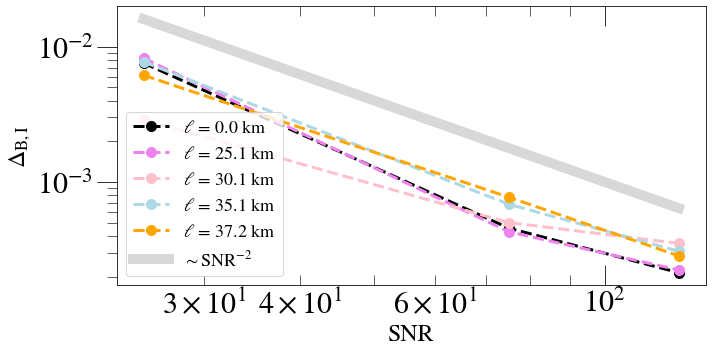

In [12]:
def BayesWaveOverlap(p):
    """ Given a BW run directory p, read in the injected and recovered strains in the 
        time domain and compute an overlap """
    
    ## Median data and bounds
    time_bw_H1, strain_bw_H1, strain_bw_2, strain_bw_3, strain_bw_4, strain_bw_5 = GetMedianData(p, det = "H1")
    time_bw_L1, strain_bw_L1, strain_bw_2, strain_bw_3, strain_bw_4, strain_bw_5 = GetMedianData(p, det = "L1")
    
    ## Injected data
    time_inj_H1, strain_inj_H1 = GetInjectedData(p, det = "H1")
    time_inj_L1, strain_inj_L1 = GetInjectedData(p, det = "L1")
    
    overlap = ComputeMultiDetectorOverlap(time_bw_H1, strain_bw_H1, time_bw_L1, strain_bw_L1, \
                                time_inj_H1, strain_inj_H1, time_inj_L1, strain_inj_L1)
    #overlap = ComputeOverlap(time_bw_H1, strain_bw_H1, time_inj_H1, strain_inj_H1, psd = True)

    return overlap

def BayesWaveOverlapFrequency(p):
    
    """ Given a BW run directory p, read in the injected and recovered strains in the 
        frequency domain and compute an overlap """
    
    ## Median data and bounds
    freq_bw_H1, strain_bw_H1, strain_bw_2, strain_bw_3, strain_bw_4, strain_bw_5 = GetBWFrequencyDomainWaveform(p, "H1")
    freq_bw_L1, strain_bw_L1, strain_bw_2, strain_bw_3, strain_bw_4, strain_bw_5 = GetBWFrequencyDomainWaveform(p, "L1")
    
    ## Injected data
    freq_inj_H1, strain_inj_H1 = GetInjectedFrequencyDomainWaveform(p, "H1")
    freq_inj_L1, strain_inj_L1 = GetInjectedFrequencyDomainWaveform(p, "L1")
    delta_f = freq_inj_L1[1] - freq_inj_L1[0]

    overlap = ComputeMultiDetectorOverlapFrequency(delta_f, strain_bw_H1, strain_bw_L1, strain_inj_H1, strain_inj_L1)
    #overlap = ComputeOverlapFrequency(delta_f, strain_bw_H1, strain_inj_H1, psd = True)

    return overlap
     
def PlotBayesWaveOverlap():
    """ Create a plot of the overlap between BW injected and recovered waveforms as
        a function of SNR. Similar to Fig. 4 in https://arxiv.org/abs/2003.09456 """
    
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/"
    mass = 68

    ells = ["0p0", "0p25", "0p3", "0p35", "0p37"]
    colors = ['black', 'violet', 'pink', 'lightblue', 'orange']
    snrs = [25, 75, 125]

    plt.figure(figsize=(10, 5))

    for ell, color in zip(ells, colors):

        delta_arr = []

        for snr in snrs:

            p = base_dir + "dCS_" + ell + "_" + str(snr)
            overlap = BayesWaveOverlapFrequency(p)
            print(ell, snr, overlap)
            delta = 1.0 - overlap
            delta_arr.append(delta)

        plt.plot(snrs, delta_arr, '--o', color = color, label = "$\ell$ = %.1f km" % EllinKm(ell, mass), markersize = 10)

    ## Add in 1/SNR^2 curve 
    SNRS = np.linspace(snrs[0], snrs[-1], 100)
    snr_curve = SNRS**-2.0
    plt.plot(SNRS, snr_curve*10, color='gray', label = r'$\sim \mathrm{SNR}^{-2}$', alpha = 0.3, lw = 10.0)

    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('$\Delta_\mathrm{B,I}$')
    plt.xlabel('SNR')
    plt.tight_layout()
    plt.savefig('Deltas.pdf')
    plt.show()
    
PlotBayesWaveOverlap()

## Plot evidences

In [5]:
def GetEvidenceTemps(base_dir):
    """ evidence.dat file looks like 
        signal 857281.232665 0.0105919
        glitch 0 0
        noise 0 0
        
        Here we're going to return the (0,1)
        entry, which in this case is 857281.232665
    """
    f = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/' + base_dir + "/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/signal_evidence.dat"
    temp, evidence = np.loadtxt(f, comments="#",usecols=([0, 1]),unpack=True)
    print(len(temp))
    
    return temp, evidence

def GetEvidence(base_dir):
    """ evidence.dat file looks like 
        signal 857281.232665 0.0105919
        glitch 0 0
        noise 0 0
        
        Here we're going to return the (0,1)
        entry, which in this case is 857281.232665
    """
    
    f = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/' + base_dir + "/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/evidence.dat"
 
    ev, variance = np.loadtxt(f, comments="#",usecols=([1, 2]),unpack=True)
    
    ev = ev[0]
    ev_err = sqrt(variance[0])
    
    return ev, ev_err


In [6]:
# fig = plt.figure(figsize=(10, 6))
    
# ell = ["0p0", "0p25", "0p3", "0p35", "0p37"]
# ell_km = np.array([EllinKm(l, 68) for l in ell])**4

# for SNR in ['25','75','125']:
    
#     BW_Evidence = np.zeros(len(ell))
#     BW_Evidence_err = np.zeros(len(ell))

#     for i, l in enumerate(ell):
#         base_dir = 'dCS_' + l + '_' + SNR
#         ev, ev_err = GetEvidence(base_dir) 
#         BW_Evidence[i] = ev
#         BW_Evidence_err[i] = ev_err
    
#     plt.errorbar(ell_km, BW_Evidence, yerr=BW_Evidence_err, linestyle='--', label=SNR, linewidth=3)
#     plt.plot(ell_km, BW_Evidence, 'o', markersize=8)
#     print(min(BW_Evidence), max(BW_Evidence))
    
# #plt.ylabel(r'Quantity relative to $\ell = 0$ value', fontsize=30)
# plt.xlabel(r'$\ell [km]$', fontsize=30)
# plt.ylabel('Bayeswave evidence')

# plt.legend(fontsize=20)
# plt.tight_layout()
# plt.savefig('Evidence.pdf') 
# plt.show()



In [7]:
# ## Plot the Bayeswave evidences
# fig = plt.figure(figsize=(10, 6))
    
# #for SNR in ['25', '75', '125']:
# SNR = '125'
# for ell in ["0p0", "0p25", "0p3", "0p35", "0p37"]:
    
#     base_dir = 'dCS_' + ell + '_' + SNR
#     temp, evidence = GetEvidenceTemps(base_dir) 
#     plt.plot(temp, evidence, '-o', label = ell)
    
# plt.xscale('log')
# plt.ylabel(r'Evidence', fontsize=30)
# plt.xlabel(r'$\beta$', fontsize=30)
# plt.legend(frameon=False, fontsize=20)
# plt.tight_layout()
# #plt.savefig('EvidenceTemps.pdf') 
# plt.show()